# Abundance Matching

### Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import scipy.integrate as integrate
from tqdm import trange
import pymc3 as pm
import theano
import theano.tensor as tt
from astropy import units as u
from astropy.cosmology import WMAP5, WMAP7
from astropy.coordinates import Distance


%matplotlib inline

## Datos

#### Finkelstein

In [24]:
file = open('Finkelstein/ApJ810_2015/apj810.tsv','r')

k=0
for row in file.readlines():
    if (not '#' in row) and row!="\n":
        break
    else:
        k+=1
file.close()

fink_a = pd.read_csv('Finkelstein/ApJ810_2015/apj810.tsv',sep=";", skiprows=k)
fink_a = fink_a.iloc[2:]
fink_a.ID = [r.replace(" ","") for r in fink_a.ID.values]
fink_a.iloc[:,6:] = fink_a.iloc[:,6:].astype(float)
fink_a

,_RAJ2000,_DEJ2000,ID,HRG14,RAJ2000,DEJ2000,zphot,b_zphot,B_zphot,1500Mag,b_1500Mag,B_1500Mag
2,053.12903194,-27.77220889,z4_GSD_7082,HRG14 J033230.97-274620.0,053.129032,-27.772209,2.83,1.3,4.33,-17.8,-18.37,-17.25
3,053.10157389,-27.80856306,z4_GSD_18977,HRG14 J033224.38-274830.8,053.101574,-27.808563,3.13,1.25,4.51,-17.86,-18.29,-16.94
4,053.10408389,-27.81275389,z4_GSD_20362,HRG14 J033224.98-274845.9,053.104084,-27.812754,3.23,3.1,4.38,-18.93,-19.51,-18.63
5,053.03509500,-27.78334389,z4_GSD_10712,HRG14 J033208.42-274700.0,053.035095,-27.783344,3.28,0.86,4.5,-16.96,-17.43,-16
6,053.08642194,-27.84164000,z4_GSD_29649,HRG14 J033220.74-275029.9,053.086422,-27.841640,3.3,2.1,4.08,-18.27,-18.93,-18.12
...,...,...,...,...,...,...,...,...,...,...,...,...
7443,053.26932500,-27.84805500,z8_PAR2_957,HRG14 J033304.64-275053.0,053.269325,-27.848055,7.61,7.18,7.85,-19.9,-19.93,-19.74
7444,053.27904500,-27.84109111,z8_PAR2_428,HRG14 J033306.97-275027.9,053.279045,-27.841091,8.21,3.34,9.41,-18.74,-19,-18.53
7445,064.12686194,-24.10006694,z8_MACS0416PAR_797,HRG14 J041630.45-240600.2,064.126862,-24.100067,7.99,6.71,8.29,-18.86,-18.9,-18.73
7446,064.12678500,-24.10031694,z8_MACS0416PAR_851,HRG14 J041630.43-240601.1,064.126785,-24.100317,8.25,7.53,8.67,-18.9,-18.99,-18.67


In [19]:
f = fink_a['1500Mag'].astype(float).unique()
f.sort()
f

array([-22.75, -22.7 , -22.65, -22.63, -22.46, -22.43, -22.35, -22.29,
       -22.25, -22.17, -22.12, -22.11, -22.08, -22.06, -22.05, -22.03,
       -22.  , -21.95, -21.92, -21.91, -21.83, -21.82, -21.8 , -21.78,
       -21.77, -21.74, -21.73, -21.71, -21.69, -21.67, -21.66, -21.65,
       -21.64, -21.63, -21.62, -21.61, -21.6 , -21.59, -21.58, -21.57,
       -21.56, -21.55, -21.54, -21.53, -21.52, -21.51, -21.5 , -21.48,
       -21.47, -21.46, -21.45, -21.44, -21.43, -21.42, -21.41, -21.4 ,
       -21.39, -21.38, -21.37, -21.36, -21.35, -21.34, -21.33, -21.32,
       -21.31, -21.3 , -21.29, -21.28, -21.27, -21.26, -21.24, -21.23,
       -21.22, -21.21, -21.2 , -21.19, -21.18, -21.17, -21.16, -21.15,
       -21.14, -21.13, -21.12, -21.11, -21.1 , -21.09, -21.08, -21.07,
       -21.06, -21.05, -21.04, -21.03, -21.02, -21.01, -21.  , -20.99,
       -20.98, -20.97, -20.96, -20.95, -20.94, -20.93, -20.92, -20.91,
       -20.9 , -20.89, -20.88, -20.87, -20.86, -20.85, -20.84, -20.83,
      

In [3]:
file = open('Finkelstein/ApJ814_2015/apj814.tsv','r')
k=0
for row in file.readlines():
    if (not '#' in row) and row!="\n":
        break
    else:
        k+=1

fink_b = pd.read_csv('Finkelstein/ApJ814_2015/apj814.tsv',sep=";", skiprows=k)
fink_b = fink_b.iloc[2:]
fink_b.ID = [r.replace(" ","") for r in fink_b.ID.values]

fink = pd.merge(fink_a,fink_b, on=['ID','RAJ2000','DEJ2000','_RAJ2000', '_DEJ2000'])
fink

,_RAJ2000,_DEJ2000,ID,HRG14,RAJ2000,DEJ2000,zphot,b_zphot,B_zphot,1500Mag,...,Age,b_Age,B_Age,E(B-V),b_E(B-V),B_E(B-V),SFR,b_SFR,B_SFR,Simbad
0,053.09684000,-27.86607389,z4_GSD_34736,HRG14 J033223.24-275157.9,053.096840,-27.866074,3.51,0.38,3.64,-21.36,...,10,19,101,0.34,0.18,0.34,451,109,434,Simbad
1,053.08689111,-27.84413889,z4_GSD_30292,HRG14 J033220.85-275038.9,053.086891,-27.844139,3.54,0.40,3.70,-21.03,...,57,49,90,0.24,0.16,0.32,132,64,322,Simbad
2,053.08736806,-27.83953500,z4_GSD_29028,HRG14 J033220.97-275022.3,053.087368,-27.839535,3.60,3.48,3.73,-21.03,...,80,80,101,0.10,0.06,0.10,38,25,40,Simbad
3,053.12141389,-27.81462111,z4_GSD_21002,HRG14 J033229.14-274852.6,053.121414,-27.814621,3.63,3.57,3.73,-21.18,...,30,10,30,0.18,0.16,0.24,93,70,152,Simbad
4,053.03123889,-27.78521500,z4_GSD_11269,HRG14 J033207.50-274706.8,053.031239,-27.785215,3.63,3.53,3.77,-21.30,...,49,40,101,0.10,0.10,0.24,45,43,176,Simbad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,189.03248611,+62.21641500,z7_GNW_17001,HRG14 J123607.80+621259.1,189.032486,+62.216415,6.84,6.58,7.03,-21.12,...,404,286,570,0.06,0.02,0.12,22,14,37,Simbad
169,189.36171000,+62.29437306,z7_GNW_24671,HRG14 J123726.81+621739.7,189.361710,+62.294373,6.93,6.27,7.38,-21.22,...,19,10,40,0.10,0.00,0.10,37,11,33,Simbad
170,189.09452806,+62.13554000,z7_GNW_4703,HRG14 J123622.69+620807.9,189.094528,+62.135540,7.19,7.04,7.40,-21.71,...,39,10,49,0.02,0.00,0.10,27,22,61,Simbad
171,189.27339194,+62.32478306,z7_GNW_19939,HRG14 J123705.61+621929.2,189.273392,+62.324783,7.24,6.81,7.69,-21.04,...,10,10,30,0.10,0.00,0.12,34,14,42,Simbad


#### Bouwens

In [4]:
#!head -n 40 'Bouwens 2015/2015bouwensApJ803.tsv'

In [5]:
for z in range(4,9):
    print('Para z=%.1f la Lambda_0 se encuentra entre %.0f - %.0f angstrong' % (z,15000/(1+z),20000/(1+z)))

Para z=4.0 la Lambda_0 se encuentra entre 3000 - 4000 angstrong
Para z=5.0 la Lambda_0 se encuentra entre 2500 - 3333 angstrong
Para z=6.0 la Lambda_0 se encuentra entre 2143 - 2857 angstrong
Para z=7.0 la Lambda_0 se encuentra entre 1875 - 2500 angstrong
Para z=8.0 la Lambda_0 se encuentra entre 1667 - 2222 angstrong


In [6]:
file = open('Bouwens 2015/2015bouwensApJ803.tsv','r')

k=0
for row in file.readlines():
    if (not '#' in row) and row!="\n":
        break
    else:
        k+=1
        
bw2015 = pd.read_csv('Bouwens 2015/2015bouwensApJ803.tsv',sep=";", skiprows=k, usecols=[0,1,2,3,4,5,6,8])
bw2015 = bw2015.iloc[2:]
bw2015.iloc[:,3:] = bw2015.iloc[:,3:].astype(float)
bw2015

,ID,RAJ2000,DEJ2000,F160W,zset,dset,zphot,OCat
2,HUDF092B-3053452227,03 33 05.34,-27 52 22.7,28.83,4,3,3.87,0
3,HUDF092B-3046852195,03 33 04.68,-27 52 19.5,27.11,4,3,3.45,0
4,HUDF092B-3045052182,03 33 04.50,-27 52 18.2,27.75,4,3,3.45,0
5,HUDF092B-3047752095,03 33 04.77,-27 52 09.5,27.77,4,3,2.87,0
6,HUDF092B-3073952111,03 33 07.39,-27 52 11.1,27.29,4,3,3.82,0
...,...,...,...,...,...,...,...,...
10418,GNDJ-2545743169,12 36 25.45,+62 14 31.6,25.93,10,6,10.2,0
10419,GNDJ-2273942274,12 37 22.73,+62 14 22.7,26.75,10,6,9.9,0
10420,GNWJ-0408242996,12 36 04.08,+62 14 29.9,26.75,10,6,9.5,0
10421,XDFJ-3811362435,03 32 38.11,-27 46 24.3,29.46,10,6,9.78,0


<img src="https://cdn.mathpix.com/snip/images/WTuNW8HreMYZDdZBvWGW1rW9nSD4COOjsfjqS6Xq3aY.original.fullsize.png" />

In [7]:
uvf_bw_z4 = pd.read_csv("Bouwens 2015/bowensz4.csv", names=['M','phi','err_phi']) 
uvf_bw_z4['Mass'] = np.log10(120 * np.power(10,-0.4 * (uvf_bw_z4.M.values - 4.62)))
uvf_bw_z5 = pd.read_csv("Bouwens 2015/bowensz5.csv", names=['M','phi','err_phi']) 
uvf_bw_z5['Mass'] = np.log10(120 * np.power(10,-0.4 * (uvf_bw_z5.M.values - 4.62)))
uvf_bw_z6 = pd.read_csv("Bouwens 2015/bowensz6.csv", names=['M','phi','err_phi']) 
uvf_bw_z6['Mass'] = np.log10(120 * np.power(10,-0.4 * (uvf_bw_z6.M.values - 4.62)))

#### Behroozi 2019

In [61]:
uvf_bw_z4.err_phi

0     0.000004
1     0.000009
2     0.000023
3     0.000040
4     0.000063
5     0.000113
6     0.000185
7     0.000255
8     0.000446
9     0.001043
10    0.002229
11    0.003500
12    0.007860
Name: err_phi, dtype: float64

In [124]:
smf_z4=pd.read_csv("umachine-dr1/data/smfs/smf_a0.202435.dat", skiprows=3,sep="\s", engine='python')
smf_z4

,#Log10(SM_Center),Number_Density,Err+,Err-,Satellite_fraction,Err+.1,Err-.1,Q_Number_Density,Err+.2,Err-.2,SM_Left_Edge,SM_Right_Edge
0,7.3,5.828010e-02,1.340610e-02,5.364260e-03,0.184588,0.020796,0.008695,6.037090e-07,7.848220e-06,3.018550e-07,7.2,7.4
1,7.5,4.550130e-02,1.183380e-02,4.624110e-03,0.208553,0.024371,0.007259,2.012360e-06,1.177230e-05,1.308040e-06,7.4,7.6
2,7.7,3.445610e-02,9.932430e-03,3.221800e-03,0.229202,0.027668,0.004103,1.308040e-06,1.499210e-05,1.006180e-07,7.6,7.8
3,7.9,2.533230e-02,7.583800e-03,2.203040e-03,0.241518,0.029517,0.002275,1.710510e-06,1.549520e-05,4.024730e-07,7.8,8.0
4,8.1,1.828770e-02,5.433180e-03,1.660300e-03,0.240898,0.031134,-0.000621,2.515460e-06,1.177230e-05,1.106800e-06,8.0,8.2
5,8.3,1.289730e-02,3.547500e-03,1.174520e-03,0.233709,0.030987,-0.001284,1.710510e-06,1.157110e-05,1.006180e-06,8.2,8.4
6,8.5,9.007040e-03,2.216420e-03,7.972990e-04,0.223935,0.027615,0.000559,2.112980e-06,1.408660e-05,1.609890e-06,8.4,8.6
7,8.7,6.254930e-03,1.306020e-03,5.652730e-04,0.209362,0.025367,-0.000867,4.930290e-06,1.126920e-05,4.427200e-06,8.6,8.8
8,8.9,4.305050e-03,7.402480e-04,3.913040e-04,0.195111,0.020707,0.000613,7.747600e-06,1.187300e-05,7.445750e-06,8.8,9.0
9,9.1,2.925880e-03,4.258160e-04,2.822340e-04,0.184222,0.017312,0.001769,7.646990e-06,1.519340e-05,7.546370e-06,9.0,9.2


In [187]:
uvf_z4=pd.read_csv("umachine-dr1/data/uvlfs/uvlf_a0.202435.dat", skiprows=3,sep="\s", engine='python')
uvf_z5=pd.read_csv("umachine-dr1/data/uvlfs/uvlf_a0.166998.dat", skiprows=3,sep="\s", engine='python')
uvf_z6=pd.read_csv("umachine-dr1/data/uvlfs/uvlf_a0.141685.dat", skiprows=3,sep="\s", engine='python')
uvf_z7=pd.read_csv("umachine-dr1/data/uvlfs/uvlf_a0.126498.dat", skiprows=3,sep="\s", engine='python')
uvf_z8=pd.read_csv("umachine-dr1/data/uvlfs/uvlf_a0.109623.dat", skiprows=3,sep="\s", engine='python')

hmf_z4=pd.read_csv("umachine-dr1/data/hmfs/hmf_a0.202435.dat", skiprows=2,sep="\s", engine='python')
hmf_z5=pd.read_csv("umachine-dr1/data/hmfs/hmf_a0.166998.dat", skiprows=2,sep="\s", engine='python')
hmf_z6=pd.read_csv("umachine-dr1/data/hmfs/hmf_a0.141685.dat", skiprows=2,sep="\s", engine='python')
hmf_z7=pd.read_csv("umachine-dr1/data/hmfs/hmf_a0.126498.dat", skiprows=2,sep="\s", engine='python')
hmf_z8=pd.read_csv("umachine-dr1/data/hmfs/hmf_a0.109623.dat", skiprows=2,sep="\s", engine='python')

smf_z4=pd.read_csv("umachine-dr1/data/smfs/smf_a0.202435.dat", skiprows=3,sep="\s", engine='python')
smf_z5=pd.read_csv("umachine-dr1/data/smfs/smf_a0.166998.dat", skiprows=3,sep="\s", engine='python')
smf_z6=pd.read_csv("umachine-dr1/data/smfs/smf_a0.141685.dat", skiprows=3,sep="\s", engine='python')
smf_z7=pd.read_csv("umachine-dr1/data/smfs/smf_a0.126498.dat", skiprows=3,sep="\s", engine='python')
smf_z8=pd.read_csv("umachine-dr1/data/smfs/smf_a0.109623.dat", skiprows=3,sep="\s", engine='python')

uvsm_z4=pd.read_csv("umachine-dr1/data/uvsm/uvsm_z3.5-z4.5.dat", skiprows=3,sep="\s", engine='python')
uvsm_z5=pd.read_csv("umachine-dr1/data/uvsm/uvsm_z4.5-z5.5.dat", skiprows=3,sep="\s", engine='python')
uvsm_z6=pd.read_csv("umachine-dr1/data/uvsm/uvsm_z5.5-z6.5.dat", skiprows=3,sep="\s", engine='python')
uvsm_z7=pd.read_csv("umachine-dr1/data/uvsm/uvsm_z6.5-z7.5.dat", skiprows=3,sep="\s", engine='python')
uvsm_z8=pd.read_csv("umachine-dr1/data/uvsm/uvsm_z7.5-z8.5.dat", skiprows=3,sep="\s", engine='python')

smhm_z4=pd.read_csv("umachine-dr1/data/smhm/averages/sm_averages_a0.202435.dat", skiprows=6,sep="\s", engine='python')
smhm_z5=pd.read_csv("umachine-dr1/data/smhm/averages/sm_averages_a0.166998.dat", skiprows=6,sep="\s", engine='python')
smhm_z6=pd.read_csv("umachine-dr1/data/smhm/averages/sm_averages_a0.141685.dat", skiprows=6,sep="\s", engine='python')
smhm_z7=pd.read_csv("umachine-dr1/data/smhm/averages/sm_averages_a0.126498.dat", skiprows=6,sep="\s", engine='python')
smhm_z8=pd.read_csv("umachine-dr1/data/smhm/averages/sm_averages_a0.109623.dat", skiprows=6,sep="\s", engine='python')

z=0
f_b = WMAP7.Ob(z) / WMAP7.Om(z)

smhm_z4.insert(7,'Q*',np.power(10,smhm_z4['Log_SMHM(4)'].values - np.log10(f_b)))
smhm_z4.insert(8,'Err+Q*',np.power(10,smhm_z4['Log_SMHM(4)'].values + smhm_z4['Err+(5)'].values - np.log10(f_b)))
smhm_z4.insert(9,'Err-Q*',np.power(10,smhm_z4['Log_SMHM(4)'].values - smhm_z4['Err-(6)'].values - np.log10(f_b)))
smhm_z4[smhm_z4['Log_SMHM(4)'] == 0] = 0

smhm_z5.insert(7,'Q*',np.power(10,smhm_z5['Log_SMHM(4)'].values - np.log10(f_b)))
smhm_z5.insert(8,'Err+Q*',np.power(10,smhm_z5['Log_SMHM(4)'].values + smhm_z5['Err+(5)'].values - np.log10(f_b)))
smhm_z5.insert(9,'Err-Q*',np.power(10,smhm_z5['Log_SMHM(4)'].values - smhm_z5['Err-(6)'].values - np.log10(f_b)))
smhm_z5[smhm_z5['Log_SMHM(4)'] == 0] = 0


smhm_z6.insert(7,'Q*',np.power(10,smhm_z6['Log_SMHM(4)'].values - np.log10(f_b)))
smhm_z6.insert(8,'Err+Q*',np.power(10,smhm_z6['Log_SMHM(4)'].values + smhm_z6['Err+(5)'].values - np.log10(f_b)))
smhm_z6.insert(9,'Err-Q*',np.power(10,smhm_z6['Log_SMHM(4)'].values - smhm_z6['Err-(6)'].values - np.log10(f_b)))
smhm_z6[smhm_z6['Log_SMHM(4)'] == 0] = 0

smhm_z7.insert(7,'Q*',np.power(10,smhm_z7['Log_SMHM(4)'].values - np.log10(f_b)))
smhm_z7.insert(8,'Err+Q*',np.power(10,smhm_z7['Log_SMHM(4)'].values + smhm_z7['Err+(5)'].values - np.log10(f_b)))
smhm_z7.insert(9,'Err-Q*',np.power(10,smhm_z7['Log_SMHM(4)'].values - smhm_z7['Err-(6)'].values - np.log10(f_b)))
smhm_z7[smhm_z7['Log_SMHM(4)'] == 0] = 0

smhm_z8.insert(7,'Q*',np.power(10,smhm_z8['Log_SMHM(4)'].values - np.log10(f_b)))
smhm_z8.insert(8,'Err+Q*',np.power(10,smhm_z8['Log_SMHM(4)'].values + smhm_z8['Err+(5)'].values - np.log10(f_b)))
smhm_z8.insert(9,'Err-Q*',np.power(10,smhm_z8['Log_SMHM(4)'].values - smhm_z8['Err-(6)'].values - np.log10(f_b)))
smhm_z8[smhm_z8['Log_SMHM(4)'] == 0] = 0

In [253]:
!head 'umachine-dr1/observational_constraints/finkelstein_z3.5_z4.5.uvlf'

#type: uvlf
#ref: http://lanl.arxiv.org/abs/1410.5439
#zlow: 3.5
#zhigh: 4.5
-22.75 -22.25 -5.031 0.239 0.253
-22.25 -21.75 -4.559 0.194 0.198
-21.75 -21.25 -3.924 0.172 0.172
-21.25 -20.75 -3.527 0.167 0.167
-20.75 -20.25 -3.188 0.166 0.166
-20.25 -19.75 -2.900 0.165 0.165


In [258]:
cols = ['M_b','M_B','Log_N','Err+','Err-']

uvf_z4_fink=pd.read_csv("umachine-dr1/observational_constraints/finkelstein_z3.5_z4.5.uvlf",names=cols, skiprows=4,sep="\s", engine='python')
uvf_z5_fink=pd.read_csv("umachine-dr1/observational_constraints/finkelstein_z4.5_z5.5.uvlf",names=cols, skiprows=4,sep="\s", engine='python')
uvf_z6_fink=pd.read_csv("umachine-dr1/observational_constraints/finkelstein_z5.5_z6.5.uvlf",names=cols, skiprows=4,sep="\s", engine='python')
uvf_z7_fink=pd.read_csv("umachine-dr1/observational_constraints/finkelstein_z6.5_z7.5.uvlf",names=cols, skiprows=4,sep="\s", engine='python')
uvf_z8_fink=pd.read_csv("umachine-dr1/observational_constraints/finkelstein_z7.5_z8.5.uvlf",names=cols, skiprows=4,sep="\s", engine='python')

uvf_z_fink

,M_b,M_B,Log_N,Err+,Err-
0,-21.75,-21.25,-5.101,0.534,0.593
1,-21.25,-20.75,-4.824,0.508,0.537
2,-20.75,-20.25,-4.211,0.478,0.482
3,-20.25,-19.75,-3.959,0.478,0.484
4,-19.75,-19.25,-3.664,0.532,0.593
5,-19.25,-18.75,-3.217,0.503,0.523
6,-18.75,-18.25,-2.821,0.518,0.557


## Abundance Matching

### Técnica $1/V_\max$

Seguiremos el trabajo de Berhoorzi et al. 2010 para este método. Primero es hayar la función de luminosidad de la muestra de galaxias analizadas, para ello seguiremos los métodos de Weigel et al. 2016. El primero de todo es la técnica basada en el volumen de comovimiento:
$$
\Phi_{j} \mathrm{d} \log M=\sum_{i}^{N_{\text {bin }}} \frac{w_{\text {spec }, i}}{V_{\text {max }, i}}
$$

Donde para el intervalo de magnitud $j$ tenemos que $N_{\text{bin}}$ es el número de la muestra en ese intervalo, $w_{\text{spec},i}$ es el complemento espectroscópico que tomaremos de Ilbert et al. 2005 y $V_{\text{max},i}$ es el volumen de comovimiento máximo, descrito como:
$$
V_{\max , i}=\frac{4 \pi}{3} \frac{\Omega^{\mathrm{s}}}{\Omega^{\mathrm{sky}}}\left(d_{\mathrm{c}}\left(z_{\max , i}\right)^{3}-d_{\mathrm{c}}\left(z_{\min , i}\right)^{3}\right)
$$

donde $\Omega^{\mathrm{sky}}$ es el área total del cielo $4\pi\ \mathrm{sr}\simeq 41253 \mathrm{deg}^2$, $\Omega^s$ es el área del estudio analizado, $d_c$ es la distancia de comovimiento, $z_{\min,i}$ es el redshift mínimo del estudio y $z_{\max,i}=\min \{z_{\max}^s,z_{\max,i}^{m}\}$ donde $z_{\max}^s$ es el redshift máximo del estudio y $z_{\max,i}^{m}$ es el redshift máximo al que se podría detectar la muestra $i$.

In [9]:
def v_max(Omega_s,z_max,z_min,cos_model):
    d_max = cos_model.comoving_distance(z_max)
    d_min = cos_model.comoving_distance(z_min)
    Omega_sky = 4*np.pi *(180/np.pi)**2
    coef = (4*np.pi/3) * (Omega_s/Omega_sky)
    return coef * (d_max**3 - d_min**3)


Haciendo una prueba con los datos de Finkelstein et al. 2015a, donde el tamaño del estudio es de $\Omega^s=301 \mathrm{arcmin}^2 \simeq 0.0836 \mathrm{deg}^2$, por lo que si consideramos los intercalos de redhisft tomados en Fineklstein et al. 2015a y la cosmología con los parámetros de WMAP7 tenemos que:

In [10]:
z_array = np.arange(4,9)
Omega_s = 310 * (1/60)**2
for z in z_array:
    z_max = z + 0.5
    z_min = z - 0.5
    v0 = v_max(Omega_s,z_max,z_min,WMAP7)
    print('Intervalo %.1f <z< %.1f --> V_max = %.2E Mpc^3' % (z_min,z_max,v0.value))

Intervalo 3.5 <z< 4.5 --> V_max = 1.02E+06 Mpc^3
Intervalo 4.5 <z< 5.5 --> V_max = 9.22E+05 Mpc^3
Intervalo 5.5 <z< 6.5 --> V_max = 8.26E+05 Mpc^3
Intervalo 6.5 <z< 7.5 --> V_max = 7.42E+05 Mpc^3
Intervalo 7.5 <z< 8.5 --> V_max = 6.69E+05 Mpc^3


Usando los límites impuesto por cada uno de los intervalos de redshift, calculamos los $\Phi_j$ sin tener en cuenta $w_{\mathrm{spec},i}$ :

In [216]:

m_lim


2.7505354199999097

In [217]:
fink_a

,_RAJ2000,_DEJ2000,ID,HRG14,RAJ2000,DEJ2000,zphot,b_zphot,B_zphot,1500Mag,b_1500Mag,B_1500Mag
2,053.12903194,-27.77220889,z4_GSD_7082,HRG14 J033230.97-274620.0,053.129032,-27.772209,2.83,1.3,4.33,-17.8,-18.37,-17.25
3,053.10157389,-27.80856306,z4_GSD_18977,HRG14 J033224.38-274830.8,053.101574,-27.808563,3.13,1.25,4.51,-17.86,-18.29,-16.94
4,053.10408389,-27.81275389,z4_GSD_20362,HRG14 J033224.98-274845.9,053.104084,-27.812754,3.23,3.1,4.38,-18.93,-19.51,-18.63
5,053.03509500,-27.78334389,z4_GSD_10712,HRG14 J033208.42-274700.0,053.035095,-27.783344,3.28,0.86,4.5,-16.96,-17.43,-16
6,053.08642194,-27.84164000,z4_GSD_29649,HRG14 J033220.74-275029.9,053.086422,-27.841640,3.3,2.1,4.08,-18.27,-18.93,-18.12
...,...,...,...,...,...,...,...,...,...,...,...,...
7443,053.26932500,-27.84805500,z8_PAR2_957,HRG14 J033304.64-275053.0,053.269325,-27.848055,7.61,7.18,7.85,-19.9,-19.93,-19.74
7444,053.27904500,-27.84109111,z8_PAR2_428,HRG14 J033306.97-275027.9,053.279045,-27.841091,8.21,3.34,9.41,-18.74,-19,-18.53
7445,064.12686194,-24.10006694,z8_MACS0416PAR_797,HRG14 J041630.45-240600.2,064.126862,-24.100067,7.99,6.71,8.29,-18.86,-18.9,-18.73
7446,064.12678500,-24.10031694,z8_MACS0416PAR_851,HRG14 J041630.43-240601.1,064.126785,-24.100317,8.25,7.53,8.67,-18.9,-18.99,-18.67


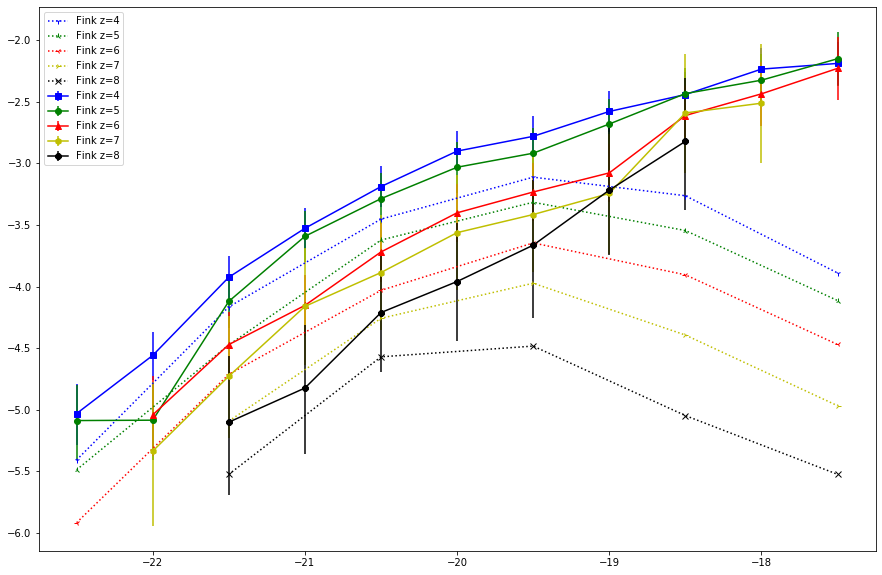

In [277]:
d_L = (1+fink_a.zphot.values)*WMAP7.comoving_distance(fink_a.zphot.values).value
m_lim = np.max(fink_a['1500Mag'].values -5 +5 * np.array([np.log10(d) for d in d_L]))
m_lim


uvf_berhoozi = [uvf_z4,uvf_z5,uvf_z6,uvf_z7,uvf_z8]
uvf_bouwens = [uvf_bw_z4,uvf_bw_z5,uvf_bw_z6]
uvf_finkelstein =[uvf_z4_fink,uvf_z5_fink,uvf_z6_fink,uvf_z7_fink,uvf_z8_fink]
#mags = uvf_bouwens[0]['M'].values
mags = np.arange(-22.5,-16.5)
z_array = np.arange(4,9)

phi = []
plt.figure(figsize=(15,10))
color = ['b','g','r','y','k']   
mark = ['s','o','^','h','8']
mark_2 = ['1','2','3','4','x']


def phi_k(table,z_max_s,z_min):
    
    phi = 0
    for i in range(table.shape[0]):
        M1500 = table.iloc[i,9]
        z_array = np.linspace(z_min,z_max_s,10)
        m_array = np.array([M1500 - 5 + 5*np.log10((1+z) * WMAP7.comoving_distance(z).value) for z in z_array])
        mask = m_array>=m_lim
        z_max = np.min(z_array[mask]) if z_array[mask].size > 0 else z_max_s
        v0 = v_max(Omega_s,z_max,z_min,WMAP7).value
        phi+= 1/v0
        if z_max < z_max_s:
            print('%f < %f'%(z_max,z_max_s))
    return phi

k = 0
for z in z_array[:5]:
    z_max_s = z + 0.5
    z_min = z - 0.5
    
    p = np.zeros(mags.size)
    i = 0
    for m in mags:
        m_max = m + 0.25
        m_min = m - 0.25
        mask = (fink_a.zphot.values >= z_min) & (fink_a.zphot.values < z_max_s) & (fink_a['1500Mag'].values >= m_min) & (fink_a['1500Mag'].values < m_max)
        table = fink_a[mask]
        p[i] = phi_k(table,z_max_s,z_min)
        i+=1
    phi.append(p)
    
    uvf = uvf_berhoozi[k]
    #uvf_bw = uvf_bouwens[k]
    uvf_fink = uvf_finkelstein[k]
    #plt.fill_between(uvf['#UV_Center'],np.log10(uvf['Number_Density']+ uvf['Err+']),np.log10(uvf['Number_Density'] - uvf['Err-']),color=color[k],alpha=0.5)
    #plt.plot(uvf['#UV_Center'], uvf['Number_Density'],c=color[k], label="Behroozi z=%i"%z)
    plt.errorbar((uvf_fink['M_b']+uvf_fink['M_B'])/2, uvf_fink['Log_N'],yerr=[uvf_fink['Err-'],uvf_fink['Err+']],color=color[k],marker=mark[k],label="Fink z=%i"%z)
    plt.plot(mags,np.log10(p), c=color[k],marker=mark_2[k],ls="dotted",label="Fink z=%i"%z)
    
    k+=1

#plt.yscale('log')
plt.legend(loc=0)
plt.show()
    

### Funciones de Behroozi

In [188]:
#uvsm_z4, smhm_z4, hmf_z4, uvf_z4
#smhm_z4.insert(7,'Log_SFR',smhm_z4['Log_SMHM(4)']-np.log10(f_b))
smhm_z4

,#Log10(HM_Center)(0),Log_SM(1),Err+(2),Err-(3),Log_SMHM(4),Err+(5),Err-(6),Q*,Err+Q*,Err-Q*,Log_True_SM(7),Err+(8),Err-(9),Log_True_SMHM(10),Err+(11),Err-(12),HM_Left_Edge(13),HM_Right_Edge(14),Bestfit_Halo_Counts(15)
0,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.0
1,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.0
2,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.0
3,8.75,3.046869,0.271773,0.215883,-5.714118,0.271773,0.215881,0.000012,0.000022,0.000007,3.064261,0.258694,0.231607,-5.696727,0.258694,0.231606,8.625,8.875,249840.0
4,9.00,3.587342,0.254439,0.241308,-5.423954,0.254442,0.241308,0.000023,0.000040,0.000013,3.605389,0.231993,0.225833,-5.405906,0.231995,0.225832,8.875,9.125,400630.0
5,9.25,4.185128,0.231956,0.216682,-5.077834,0.231953,0.216686,0.000050,0.000085,0.000030,4.203666,0.216081,0.205789,-5.059295,0.216073,0.205801,9.125,9.375,1303270.0
6,9.50,4.979884,0.206679,0.165640,-4.539493,0.206674,0.165653,0.000173,0.000278,0.000118,4.998138,0.196733,0.163772,-4.521241,0.196711,0.163794,9.375,9.625,3341610.0
7,9.75,5.807914,0.190868,0.125512,-3.934419,0.190833,0.125550,0.000695,0.001079,0.000521,5.826280,0.172151,0.118107,-3.916055,0.172114,0.118149,9.625,9.875,4191700.0
8,10.00,6.461383,0.169880,0.091885,-3.525492,0.169808,0.092027,0.001783,0.002636,0.001442,6.480016,0.148810,0.084404,-3.506855,0.148702,0.084530,9.875,10.125,3011020.0
9,10.25,6.952838,0.154979,0.080171,-3.286331,0.154857,0.080310,0.003092,0.004417,0.002570,6.971210,0.126024,0.060324,-3.267961,0.125867,0.060714,10.125,10.375,1729350.0


In [158]:
#plt.fill_between(uvf_z4['#UV_Center'],uvf_z4['Number_Density']+uvf_z4['Err+'],uvf_z4['Number_Density']-uvf_z4['Err-'])
smf_test = pd.merge(hmf_z4.iloc[:,:4], smhm_z4.sort_values('#Log10(HM_Center)(0)').iloc[:,:4],left_on='#Log10(HM)', right_on='#Log10(HM_Center)(0)')
smf_test = smf_test.sort_values('Log_SM(1)')
smf_test

,#Log10(HM),Number_Density,Err+,Err-,#Log10(HM_Center)(0),Log_SM(1),Err+(2),Err-(3)
0,8.75,2.011080e-02,3.219780e-07,0.000000e+00,8.75,3.046869,0.271773,0.215883
1,9.00,3.224850e-02,6.439570e-07,-4.024730e-07,9.00,3.587342,0.254439,0.241308
2,9.25,1.049070e-01,3.099040e-05,-1.167170e-05,9.25,4.185128,0.231956,0.216682
3,9.50,2.689810e-01,2.920340e-04,-1.004570e-04,9.50,4.979884,0.206679,0.165640
4,9.75,3.374100e-01,8.925240e-04,-2.807650e-04,9.75,5.807914,0.190868,0.125512
5,10.00,2.423710e-01,1.474740e-03,-4.135810e-04,10.00,6.461383,0.169880,0.091885
6,10.25,1.392030e-01,2.836310e-03,-7.320180e-04,10.25,6.952838,0.154979,0.080171
7,10.50,7.497630e-02,1.969700e-03,-5.341620e-04,10.50,7.380046,0.129313,0.069319
8,10.75,3.784780e-02,7.152750e-04,-1.812740e-04,10.75,7.801497,0.106550,0.063335
9,11.00,1.856130e-02,2.475210e-04,-5.908300e-05,11.00,8.223219,0.071505,0.052649


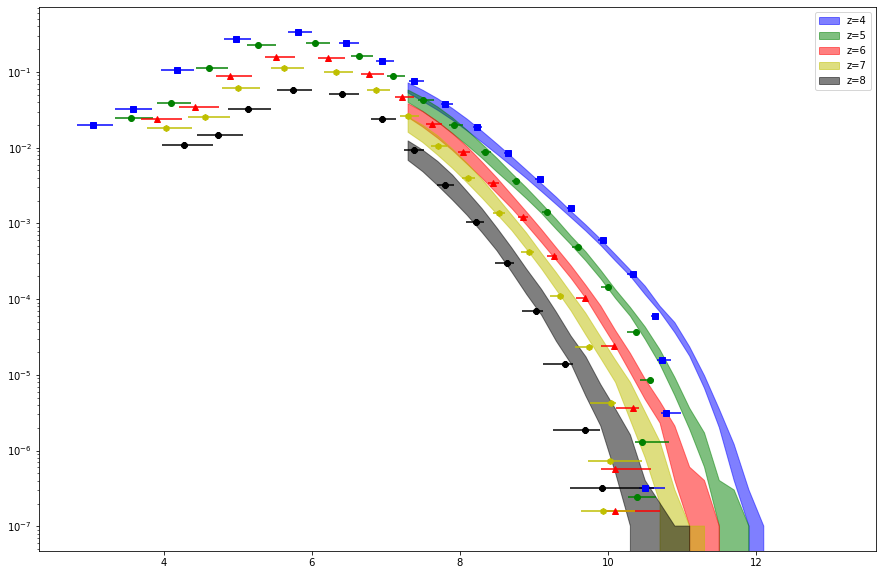

In [167]:
plt.figure(figsize=(15,10))
color = ['b','g','r','y','k']   
mark = ['s','o','^','h','8']
k = 0
smf_berhoozi = [smf_z4,smf_z5,smf_z6,smf_z7,smf_z8]
hmf_berhoozi = [hmf_z4,hmf_z5,hmf_z6,hmf_z7,hmf_z8]
smhm_berhoozi = [smhm_z4,smhm_z5,smhm_z6,smhm_z7,smhm_z8]

for z in z_array[:5]:
    smf = smf_berhoozi[k]
    smhm = smhm_berhoozi[k]
    hmf = hmf_berhoozi[k]
    smf_test = pd.merge(hmf.iloc[:,:4], smhm.sort_values('#Log10(HM_Center)(0)').iloc[:,:4],left_on='#Log10(HM)', right_on='#Log10(HM_Center)(0)')
    smf_test = smf_test.sort_values('Log_SM(1)')
    
    
    plt.fill_between(smf['#Log10(SM_Center)'],smf['Number_Density'] + smf['Err+'],
                     smf['Number_Density'] - smf['Err-'],alpha=0.5,color=color[k], label="z=%i"%z)


    plt.errorbar(smf_test['Log_SM(1)'].values,smf_test['Number_Density'].values,
                 xerr=[smf_test['Err-(3)'],smf_test['Err+(2)']],
                 yerr=[smf_test['Err-'].abs(),smf_test['Err+']],
                 color=color[k],marker=mark[k],linestyle="")
    k+=1
plt.yscale('log')
plt.legend(loc=0)
plt.show()

In [144]:
smf_test['Number_Density'] + smf_test['Err-']

0     2.011080e-02
1     3.224810e-02
2     1.048953e-01
3     2.688805e-01
4     3.371292e-01
5     2.419574e-01
6     1.384710e-01
7     7.444214e-02
8     3.766653e-02
9     1.850222e-02
10    8.610026e-03
11    3.806829e-03
12    1.597975e-03
13    6.098275e-04
14    2.128280e-04
15    6.021000e-05
16    1.577690e-05
17    3.139290e-06
18    3.219780e-07
dtype: float64

In [114]:
uvf = interp1d(uvf_z4['#UV_Center'], uvf_z4['Number_Density'])
uvf_b = interp1d(uvf_z4['#UV_Center'], uvf_z4['Number_Density']-uvf_z4['Err-'])
uvf_B = interp1d(uvf_z4['#UV_Center'], uvf_z4['Number_Density']+uvf_z4['Err+'])

uvsm = interp1d(uvsm_z4['Median_SM'], uvsm_z4['#UV_Center'])
uvsm_b = interp1d(uvsm_z4['Median_SM'], uvsm_z4['UV_Min'])
uvsm_B = interp1d(uvsm_z4['Median_SM'], uvsm_z4['UV_Max'])

smhm = interp1d(smhm_z4['#Log10(HM_Center)(0)'], smhm_z4['Log_SM(1)'])
smhm_b = interp1d(smhm_z4['#Log10(HM_Center)(0)'], smhm_z4['Log_SM(1)']-smhm_z4['Err-(3)'])
smhm_B = interp1d(smhm_z4['#Log10(HM_Center)(0)'], smhm_z4['Log_SM(1)']+smhm_z4['Err+(2)'])

h_m,h_M = smhm_z4['#Log10(HM_Center)(0)'].min(), smhm_z4['#Log10(HM_Center)(0)'].max()

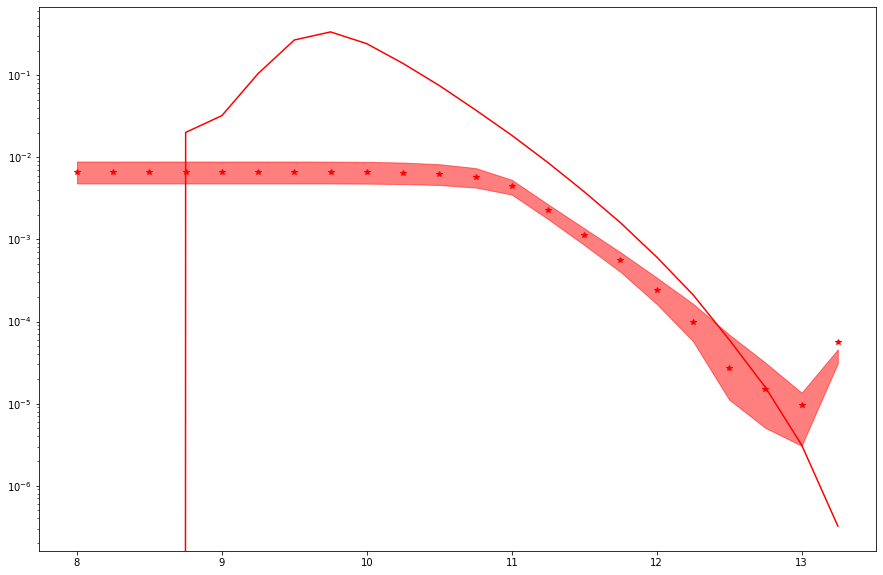

In [115]:
h = hmf_z4['#Log10(HM)'].values
mask = (h>=h_m) & (h<=h_M)
h = h[mask]
n = hmf_z4['Number_Density'].values[mask]
n_test = uvf(uvsm(np.power(10,smhm(h))))
n_b = uvf_b(uvsm_b(np.power(10,smhm_b(h))))
n_B = uvf_B(uvsm_B(np.power(10,smhm_B(h))))
plt.figure(figsize=(15,10))
plt.fill_between(h,n_B,n_b,alpha=0.5,color='r')
plt.plot(h,n,'r-')
plt.plot(h,n_test,'r*')
plt.yscale('log')


In [116]:
n_B>=n_b

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

## Conversion UV SM

In [41]:
archivos = ["HMFCalc/Seth_WMAP7/mVector_z=4 .txt","HMFCalc/Seth_WMAP7/mVector_z=5 .txt",
           "HMFCalc/Seth_WMAP7/mVector_z=6 .txt","HMFCalc/Seth_WMAP7/mVector_z=7 .txt",
           "HMFCalc/Seth_WMAP7/mVector_z=8 .txt"]
'''
archivos2 = ["HMFCalc/Seth_Planck/mVector_PLANCK-SMT z4 .txt","HMFCalc/Seth_Planck/mVector_PLANCK-SMT z5 .txt",
           "HMFCalc/Seth_Planck/mVector_PLANCK-SMT z6 .txt","HMFCalc/Seth_Planck/mVector_PLANCK-SMT z7 .txt",
           "HMFCalc/Seth_Planck/mVector_PLANCK-SMT z8 .txt"]
'''
archivos2 = ["HMFCalc/Beh-Planck/mVector_PLANCK- z = 4 .txt","HMFCalc/Beh-Planck/mVector_PLANCK- z = 5 .txt",
           "HMFCalc/Beh-Planck/mVector_PLANCK- z = 6 .txt","HMFCalc/Beh-Planck/mVector_PLANCK- z = 7 .txt",
           "HMFCalc/Beh-Planck/mVector_PLANCK- z = 8 .txt"]
hmfcalc_list=[]
hmfcalc_list2=[]

for i in range(3):
    a = archivos[i]
    hmfcalc_z=pd.read_csv(a,sep="\s",header=None, skiprows=12,engine='python')
    hmfcalc_z = hmfcalc_z.iloc[:,[0,7,11]]
    hmfcalc_z=hmfcalc_z.rename(columns={0:"M_h",7:"dn/dlog10m",11:"Lbox"})
    hmfcalc_z["M_h"]=np.log10(hmfcalc_z["M_h"].values)
    hmfcalc_list.append(hmfcalc_z)
    
    a = archivos2[i]
    hmfcalc_z=pd.read_csv(a,sep="\s",header=None, skiprows=12,engine='python')
    hmfcalc_z = hmfcalc_z.iloc[:,[0,7,11]]
    hmfcalc_z=hmfcalc_z.rename(columns={0:"M_h",7:"dn/dlog10m",11:"Lbox"})
    hmfcalc_z["M_h"]=np.log10(hmfcalc_z["M_h"].values)
    hmfcalc_list2.append(hmfcalc_z)

### Puntos Steinhardt

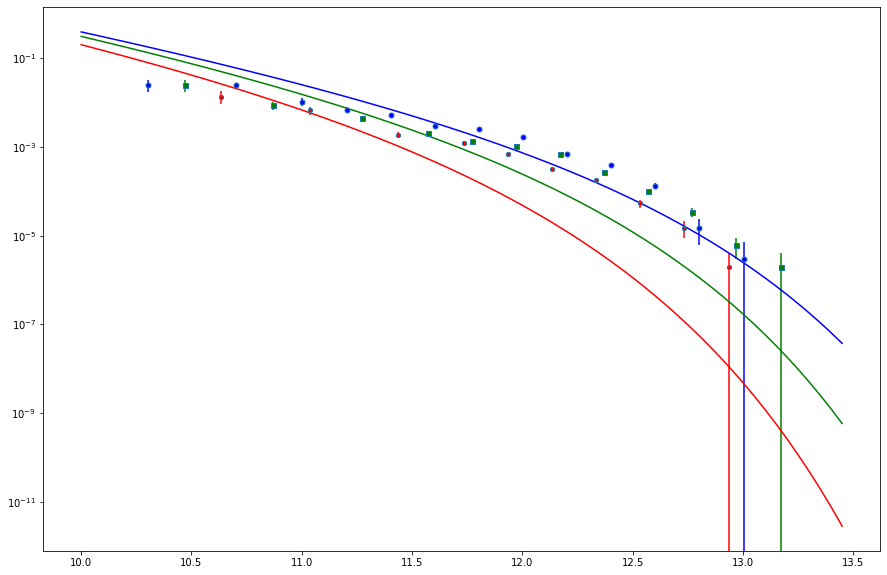

In [43]:
plt.figure(figsize=(15,10))
plt.errorbar(uvf_bw_z4.Mass,uvf_bw_z4.phi, uvf_bw_z4.err_phi,marker='o',ms=5, mfc='b',ecolor="b",linestyle="")
plt.errorbar(uvf_bw_z5.Mass,uvf_bw_z5.phi, uvf_bw_z5.err_phi,marker='s',ms=5, mfc='g',ecolor="g",linestyle="")
plt.errorbar(uvf_bw_z6.Mass,uvf_bw_z6.phi, uvf_bw_z6.err_phi,marker='8',ms=5, mfc='r',ecolor="r",linestyle="")
color = ['b','g','r']
color2 = ['b--','g--','r--']
hmf_um = [hmf_z4,hmf_z5,hmf_z6]
for i in range(3):
    
    h = hmfcalc_list[i]
    x = h.M_h.values[h.M_h.values<13.5]
    y = h['dn/dlog10m'].values[h.M_h.values<13.5]
    plt.plot(x,y, color[i])
    
    
    '''
    h = hmf_um[i]
    mask = (h['#Log10(HM)'].values<13.5) & (h['#Log10(HM)'].values>10)
    x = h['#Log10(HM)'].values[mask]
    y = h['Number_Density'].values[mask]
    ub = h['Number_Density'].values[mask] + h['Err+'].values[mask]
    db = h['Number_Density'].values[mask]+ h['Err-'].values[mask]
    #plt.plot(x,y, color[i])
    
    plt.fill_between(x,db,ub, color=color[i])'''

#plt.plot(bw_z4.M, A * p_est * (10**(-0.4*(M-m_est)*(a_est+1))) - np.exp(10**(-0.4*(M-m_est))),'r-')
plt.yscale('log')

### Behroozi

In [27]:
# Usando las curvas de Behroozi
def conv_uvsm_sfr1(z):
    if z>=3.5 and z<4.5:
        uvsm = uvsm_z4
        bw = bw_z4.copy()
        
    elif z>=4.5 and z<5.5:
        uvsm = uvsm_z5
        bw = bw_z5.copy()
    elif z>=5.5 and z<6.5:
        uvsm = uvsm_z6
        bw = bw_z6.copy()
    else:
        return pd.DataFrame({})
    
    f = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values)
    f_B = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values + uvsm['Err+'].values)
    f_b = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values - uvsm['Err-'].values)
    bw['#UV_Center'] = bw.M - bw.M % 0.25
    bw = pd.merge(bw,uvsm, on="#UV_Center")
    
    bw['SM'] = f(bw.M.values)
    bw['SM_B'] = f_B(bw.M.values)
    bw['SM_b'] = f_b(bw.M.values)
    bw['Mh'] = np.log10(bw['SM'] * 70)
    bw['Mh_B'] = np.log10(bw['SM_B'] * 70)
    bw['Mh_b'] = np.log10(bw['SM_b'] * 70)
    bw['Median_Mh'] = np.log10(bw['Median_SM'] * 70)
    
    return bw

def conv_uvsm_behroozi(z):
    if z>=3.5 and z<4.5:
        uvsm = uvsm_z4
        smhm = smhm_z4
        bw = bw_z4.copy()
        
    elif z>=4.5 and z<5.5:
        uvsm = uvsm_z5
        smhm = smhm_z4
        bw = bw_z5.copy()
    elif z>=5.5 and z<6.5:
        uvsm = uvsm_z6
        smhm = smhm_z4
        bw = bw_z6.copy()
    else:
        return pd.DataFrame({})
    
    f = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values)
    g = interp1d(smhm['Log_SM(1)'].values,smhm['#Log10(HM_Center)(0)'].values)
    f_B = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values + uvsm['Err+'].values)
    f_b = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values - uvsm['Err-'].values)
    g_b = interp1d(smhm['Err+(2)'].values,smhm['#Log10(HM_Center)(0)'].values)
    g_B = interp1d(smhm[ 'Err-(3)'].values,smhm['#Log10(HM_Center)(0)'].values)
    bw['#UV_Center'] = bw.M - bw.M % 0.25
    bw = pd.merge(bw,uvsm, on="#UV_Center")
    
    bw['SM'] = f(bw.M.values)
    bw['SM_B'] = f_B(bw.M.values)
    bw['SM_b'] = f_b(bw.M.values)
    
    bw['Mh'] = g(np.log10(bw['SM']))
    bw['Mh_B'] = g_B(np.log10(bw['SM_B']))
    bw['Mh_b'] = g_b(np.log10(bw['SM_b']))
    bw['Median_Mh'] = g(np.log10(bw['Median_SM']))
    
    return bw

In [33]:
bw = bw_z4
uvsm = uvsm_z4
smhm = smhm_z4
f = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values)
g = interp1d(smhm['Log_SM(1)'].values,smhm['#Log10(HM_Center)(0)'].values)
f_B = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values + uvsm['Err+'].values)
f_b = interp1d(uvsm['#UV_Center'].values,uvsm['Median_SM'].values - uvsm['Err-'].values)
g_b = interp1d(smhm['Err+(2)'].values,smhm['#Log10(HM_Center)(0)'].values)
g_B = interp1d(smhm[ 'Err-(3)'].values,smhm['#Log10(HM_Center)(0)'].values)
bw['#UV_Center'] = bw.M - bw.M % 0.25
bw = pd.merge(bw,uvsm, on="#UV_Center")

bw['SM'] = f(bw.M.values)
bw['SM_B'] = f_B(bw.M.values)
bw['SM_b'] = f_b(bw.M.values)

np.log10(bw['SM']).max(), smhm['Log_SM(1)'].max()

(10.878802249971022, 10.783086)

In [28]:
bz4 = conv_uvsm_behroozi(4)
bz5 = conv_uvsm_behroozi(5)
bz6 = conv_uvsm_behroozi(6)

ValueError: A value in x_new is above the interpolation range.

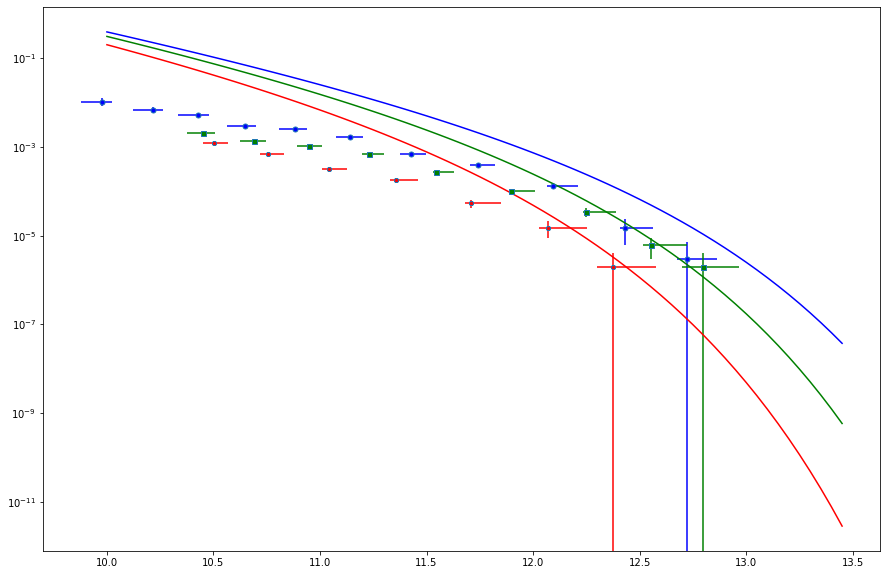

In [12]:
plt.figure(figsize=(15,10))

plt.errorbar(bz4.Mh,bz4.phi, xerr=[bz4.Mh_B-bz4.Mh, bz4.Mh-bz4.Mh_b] ,yerr=bz4.err_phi,marker='o',ms=5, mfc='b',ecolor="b",linestyle="")
plt.errorbar(bz5.Mh,bz5.phi, xerr=[bz5.Mh_B-bz5.Mh, bz5.Mh-bz5.Mh_b] ,yerr=bz5.err_phi,marker='s',ms=5, mfc='g',ecolor="g",linestyle="")
plt.errorbar(bz6.Mh,bz6.phi, xerr=[bz6.Mh_B-bz6.Mh, bz6.Mh-bz6.Mh_b] ,yerr=bz6.err_phi,marker='8',ms=5, mfc='r',ecolor="r",linestyle="")
color = ['b','g','r']
color2 = ['b--','g--','r--']
hmf_um = [hmf_z4,hmf_z5,hmf_z6]
for i in range(3):
    h = hmfcalc_list[i]
    x = h.M_h.values[h.M_h.values<13.5]
    y = h['dn/dlog10m'].values[h.M_h.values<13.5]
    plt.plot(x,y, color[i])
    '''
    h = hmf_um[i]
    mask = (h['#Log10(HM)'].values<13.5) & (h['#Log10(HM)'].values>10)
    x = h['#Log10(HM)'].values[mask]
    y = h['Number_Density'].values[mask]
    ub = h['Number_Density'].values[mask] + h['Err+'].values[mask]
    db = h['Number_Density'].values[mask]+ h['Err-'].values[mask]
    #plt.plot(x,y, color[i])
    
    plt.fill_between(x,db,ub, color=color[i])
    '''
#plt.plot(bw_z4.M, A * p_est * (10**(-0.4*(M-m_est)*(a_est+1))) - np.exp(10**(-0.4*(M-m_est))),'r-')
plt.yscale('log')

In [ ]:
# Luminosity Function Bouwens 2015
'''
z4 =[
"-22.69,0.000003,0.000004",
"-22.19,0.000015,0.000009",
"-21.69,0.000134,0.000023",
"-21.19,0.000393,0.000040",
"-20.69,0.000678,0.000063",
"-20.19,0.001696,0.000113",
"-19.69,0.002475,0.000185",
"-19.19,0.002984,0.000255",
"-18.69,0.005352,0.000446",
"-18.19,0.006865,0.001043",
"-17.69,0.010473,0.002229",
"-16.94,0.024580,0.003500",
"-15.94,0.025080,0.007860"]



z5 = [
"-23.11,0.000002,0.000002",
"-22.61,0.000006,0.000003",
"-22.11,0.000034,0.000008",
"-21.61,0.000101,0.000014",
"-21.11,0.000265,0.000025",
"-20.61,0.000676,0.000046",
"-20.11,0.001029,0.000067",
"-19.61,0.001329,0.000094",
"-19.11,0.002085,0.000171",
"-18.36,0.004460,0.000540",
"-17.36,0.008600,0.001760",
"-16.36,0.024400,0.007160",
]

z6 = [
"-22.52,0.000002,0.000002",
"-22.02,0.000015,0.000006",
"-21.52,0.000053,0.000012",
"-21.02,0.000176,0.000025",
"-20.52,0.000320,0.000041",
"-20.02,0.000698,0.000083",
"-19.52,0.001246,0.000137",
"-18.77,0.001900,0.000320",
"-17.77,0.006680,0.001380",
"-16.77,0.013640,0.004200"
]

w = open('Bouwens 2015/bowensz4.csv','w')
for l in z4:
    w.write(l+'\n')
w.close()

w = open('Bouwens 2015/bowensz5.csv','w')
for l in z5:
    w.write(l+'\n')
w.close()

w = open('Bouwens 2015/bowensz6.csv','w')
for l in z6:
    w.write(l+'\n')
w.close()
'''